In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Setup

In [2]:
xls = pd.ExcelFile('dataset/MRW_v2.xlsx')
sheet1 = pd.read_excel(xls, 'Transaction')
sheet2 = pd.read_excel(xls, 'SKU_point_Ltr')
sheet3 = pd.read_excel(xls, 'Garange Profile')
sheet4 = pd.read_excel(xls, 'User')

In [3]:
print(sheet1.shape)
# sheet1.sample(5)

(215656, 5)


In [4]:
sheet1_clean = sheet1.groupby(['Distributor', 'UserId', 'ScanDate', 'ProductName', 'ProductSKU']).agg({'ScanDate': 'count'})\
                            .rename(columns={'ScanDate': 'Qty'}).reset_index()
# sheet1_clean.head()

In [5]:
print(sheet2.shape)
# sheet2.head()

(10, 3)


In [6]:
print(sheet3.shape)
# sheet3.head()

(4006, 5)


In [7]:
print(sheet4.shape)
# sheet4.head()

(4719, 3)


In [8]:
merge_1 = pd.merge(sheet1_clean, sheet2, on='ProductSKU', how='left')
merge_2 = pd.merge(merge_1, sheet3, left_on=['UserId', 'Distributor'], right_on=['OwnerId', 'Distributor'], 
                   how='left')
mrw = pd.merge(merge_2, sheet4, on='UserId', how='left')

In [9]:
print(mrw.shape)
mrw.head()

(36015, 14)


,Distributor,UserId,ScanDate,ProductName,ProductSKU,Qty,Points,Volume (L),OwnerId,Postcode,Province,District,GarageId,UserType
0,A,EXL_1569941239614,2023-01-11,Mobil 1 Gold,Mobil 1 Gold 4L - 6L,2,60,6,EXL_1569941239614,10540.0,สมุทรปราการ,เขตบางพลี,XT8304,Owner
1,A,EXL_1569941239614,2023-01-11,Silver Large,Silver - Large 4L,2,50,4,EXL_1569941239614,10540.0,สมุทรปราการ,เขตบางพลี,XT8304,Owner
2,A,EXL_1569941239614,2023-01-14,Silver Large,Silver - Large 4L,1,50,4,EXL_1569941239614,10540.0,สมุทรปราการ,เขตบางพลี,XT8304,Owner
3,A,EXL_1569941239614,2023-02-06,Silver Large,Silver - Large 4L,5,50,4,EXL_1569941239614,10540.0,สมุทรปราการ,เขตบางพลี,XT8304,Owner
4,A,EXL_1569941239614,2023-02-07,Gold Large,Gold - Large 4L,1,50,4,EXL_1569941239614,10540.0,สมุทรปราการ,เขตบางพลี,XT8304,Owner


Handle null/ missing values

In [10]:
mrw.columns

Index(['Distributor', 'UserId', 'ScanDate', 'ProductName', 'ProductSKU', 'Qty',
       'Points', 'Volume (L)', 'OwnerId', 'Postcode', 'Province', 'District ',
       'GarageId', 'UserType'],
      dtype='object')

In [11]:
mrw.dtypes

Distributor            object
UserId                 object
ScanDate       datetime64[ns]
ProductName            object
ProductSKU             object
Qty                     int64
Points                  int64
Volume (L)              int64
OwnerId                object
Postcode              float64
Province               object
District               object
GarageId               object
UserType               object
dtype: object

In [12]:
mrw.rename(columns={'District ': 'District'}, inplace=True)
mrw.isnull().sum()

Distributor       0
UserId            0
ScanDate          0
ProductName       0
ProductSKU        0
Qty               0
Points            0
Volume (L)        0
OwnerId        3649
Postcode       3757
Province       3649
District       3649
GarageId          0
UserType          0
dtype: int64

In [13]:
# drop records with no province
null_province = mrw[ mrw['Province'].isnull() ].index
mrw.drop(index=null_province, inplace=True)
len(mrw['Province'].unique())

77

In [14]:
# fill null Postcode with 0
mrw['Postcode'] = mrw['Postcode'].fillna(0).astype('int')
mrw['Postcode'] = mrw['Postcode'].astype('str').replace('0', '-')

### EDA
Distribution of Top10 garage using (scan)

In [15]:
mrw.columns

Index(['Distributor', 'UserId', 'ScanDate', 'ProductName', 'ProductSKU', 'Qty',
       'Points', 'Volume (L)', 'OwnerId', 'Postcode', 'Province', 'District',
       'GarageId', 'UserType'],
      dtype='object')

<Axes: xlabel='ScanDate', ylabel='Qty'>

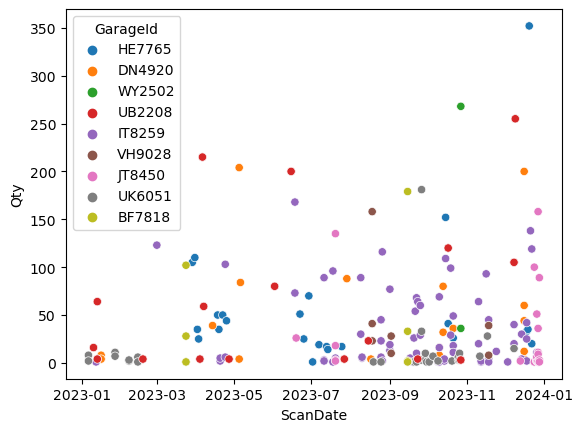

In [16]:
garage_used_per_day = mrw.groupby(['GarageId', 'ScanDate']).agg({'Qty': 'sum'}).reset_index()
top10_garage = garage_used_per_day.sort_values('Qty', ascending=False).head(10)

top10_garage_used = pd.merge(top10_garage['GarageId'], mrw, on='GarageId', how='left')
sns.scatterplot(data=top10_garage_used, x='ScanDate', y='Qty', hue='GarageId')

In [17]:
used_by_garage = mrw.groupby(['GarageId', 'Province']).agg({'Qty': 'sum'}).reset_index()
top10_used = used_by_garage.sort_values('Qty', ascending=False).head(10)
top10_used['GarageId'].values

array(['IT8259', 'IB0726', 'GD8373', 'HR9453', 'ZB1266', 'RH6974',
       'VY9051', 'NW8593', 'OC2412', 'HE7765'], dtype=object)

In [18]:
top10_garage_used = mrw.groupby(['GarageId']).agg({'Qty': 'sum'}).reset_index().\
                        sort_values('Qty', ascending=False).head(10)
top10_garage = pd.merge(top10_garage_used['GarageId'], mrw, on='GarageId', how='left')

product_per_garage = top10_garage[['GarageId', 'ProductSKU', 'Qty', 'Province']]\
                        .groupby(['GarageId', 'ProductSKU'])\
                        .agg({'Qty': 'sum'})\
                        .reset_index()
                      
# 1st rank oil  
# IT8259 (Bangkok): Silver
# NW8593 (Chantaburi): Delvac
# Others: SUper FF
product_per_garage[ product_per_garage.GarageId == 'NW8593'].sort_values('Qty')

,GarageId,ProductSKU,Qty
32,NW8593,Mobil_Delvac_Legend_6L_-_7L,4
27,NW8593,Gold - Large 4L,16
28,NW8593,Mobil 1 Gold 4L - 6L,16
30,NW8593,Mobil Super AIO - 7L,41
31,NW8593,Mobil Super FF 4L - 7L,585
29,NW8593,Mobil Delvac Modern 7L,695


Proportional product SKU

In [19]:
sku_qty_totals = mrw.groupby('ProductSKU').agg({'Qty': 'sum'}).reset_index()
sku_qty_totals = sku_qty_totals.sort_values(by='Qty', ascending=False).reset_index(drop=True)
sku_qty_totals['percent'] = sku_qty_totals['Qty'] / sku_qty_totals['Qty'].sum() * 100

# sku_qty_totals

<Figure size 600x400 with 0 Axes>

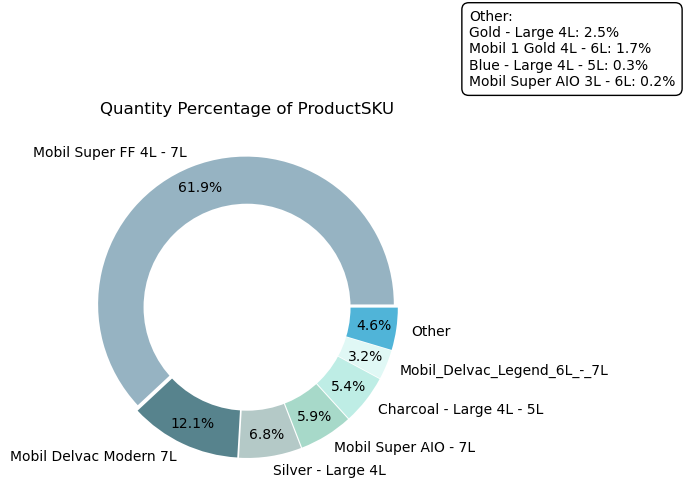

In [20]:
color = ['#96b3c2', '#57838d', '#b4c9c7', '#a7d9c9', '#beede5',
         '#e0f8f5', '#50b4d8', '#9eddef', '#b7eaf7', '#d7e2ea']
explode = (0.02, )*10
threshold = 0.03  # 3%
total_qty = sku_qty_totals['Qty'].sum()
small_slices = sku_qty_totals[sku_qty_totals['Qty'] / total_qty < threshold]
large_slices = sku_qty_totals[sku_qty_totals['Qty'] / total_qty >= threshold]

other = pd.DataFrame({'ProductSKU': ['Other'], 'Qty': [small_slices['Qty'].sum()]})
new_data = pd.concat([large_slices, other])

plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(new_data['Qty'], labels=new_data['ProductSKU'], autopct='%1.1f%%', 
                                  pctdistance=0.85, colors=color[:len(new_data)], explode=[0.02]*len(new_data))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Quantity Percentage of ProductSKU')

small_slices = small_slices.copy()
small_slices['Percentage'] = (small_slices['Qty'] / total_qty) * 100

other_contents = "\n".join([f"{row['ProductSKU']}: {row['Percentage']:.1f}%" for _, row in small_slices.iterrows()])
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black')
plt.text(1.5, 1.5, f"Other:\n{other_contents}", bbox=props, fontsize=10)

plt.show()

Text(0.5, 1.0, 'User by quarter')

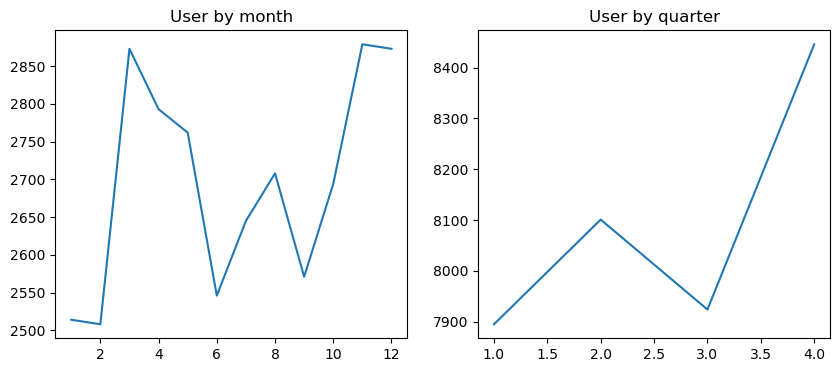

In [21]:
time_series = mrw.copy()
time_series['Month'] = mrw['ScanDate'].dt.month
time_series['Year'] = mrw['ScanDate'].dt.year
time_series['Quarter'] = mrw['ScanDate'].dt.quarter

sales_per_month = time_series.groupby(['Year', 'Month']).agg({'UserId': 'count'})\
                                .rename(columns={'UserId': 'quantity'}).reset_index()
sales_per_quarter = time_series.groupby(['Year', 'Quarter']).agg({'UserId': 'count'})\
                                .rename(columns={'UserId': 'quantity'}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(sales_per_month['Month'], sales_per_month['quantity'])
ax[0].set_title('User by month')

ax[1].plot(sales_per_quarter['Quarter'], sales_per_quarter['quantity'])
ax[1].set_title('User by quarter')

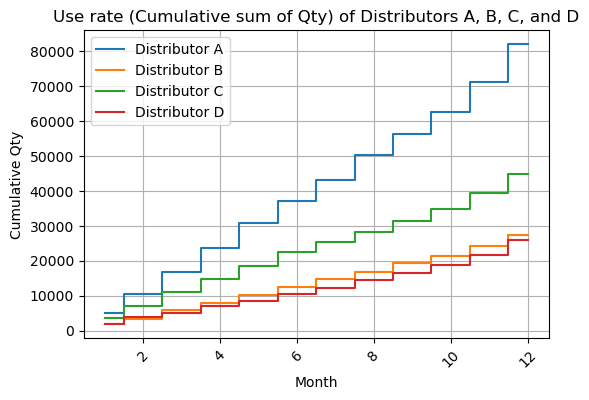

In [22]:
# Plotting the cumulative sum step plot for each distributor
plt.figure(figsize=(6, 4))

for distributor in mrw['Distributor'].unique():
    # Filter data for the current distributor
    filtered_mrw = mrw[mrw['Distributor'] == distributor]
    
    # Sort data by ScanDate
    filtered_mrw = filtered_mrw.sort_values(by='ScanDate')
    
    # Calculate cumulative sum of Qty
    filtered_mrw['CumulativeQty'] = filtered_mrw['Qty'].cumsum()
    filtered_mrw['Month'] = filtered_mrw['ScanDate'].dt.month
    monthly_cumulative = filtered_mrw.groupby('Month')['CumulativeQty'].max()
    
    # Plot the step graph
    plt.step(monthly_cumulative.index, monthly_cumulative.values, where='mid', 
            linestyle='-', label=f'Distributor {distributor}')

plt.title('Use rate (Cumulative sum of Qty) of Distributors A, B, C, and D')
plt.xlabel('Month')
plt.ylabel('Cumulative Qty')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

### Region

In [15]:
province_dict = {
    "กรุงเทพมหานคร": "ภาคกลาง",       # Bangkok - Central
    "สมุทรปราการ": "ภาคกลาง",         # Samut Prakan - Central
    "นนทบุรี": "ภาคกลาง",             # Nonthaburi - Central
    "ปทุมธานี": "ภาคกลาง",            # Pathum Thani - Central
    "พระนครศรีอยุธยา": "ภาคกลาง",    # Phra Nakhon Si Ayutthaya - Central
    "อ่างทอง": "ภาคกลาง",             # Ang Thong - Central
    "ลพบุรี": "ภาคกลาง",              # Lopburi - Central
    "สิงห์บุรี": "ภาคกลาง",            # Singburi - Central
    "ชัยนาท": "ภาคกลาง",              # Chai Nat - Central
    "สระบุรี": "ภาคกลาง",             # Saraburi - Central
    "ชลบุรี": "ภาคตะวันออก",          # Chonburi - Eastern
    "ระยอง": "ภาคตะวันออก",           # Rayong - Eastern
    "จันทบุรี": "ภาคตะวันออก",        # Chanthaburi - Eastern
    "ตราด": "ภาคตะวันออก",            # Trat - Eastern
    "ฉะเชิงเทรา": "ภาคตะวันออก",      # Chachoengsao - Eastern
    "ปราจีนบุรี": "ภาคตะวันออก",       # Prachinburi - Eastern
    "นครนายก": "ภาคตะวันออก",         # Nakhon Nayok - Eastern
    "สระแก้ว": "ภาคตะวันออก",         # Sa Kaeo - Eastern
    "นครราชสีมา": "ภาคตะวันออกเฉียงเหนือ", # Nakhon Ratchasima - Northeastern
    "บุรีรัมย์": "ภาคตะวันออกเฉียงเหนือ",    # Buriram - Northeastern
    "สุรินทร์": "ภาคตะวันออกเฉียงเหนือ",    # Surin - Northeastern
    "ศรีสะเกษ": "ภาคตะวันออกเฉียงเหนือ",    # Si Sa Ket - Northeastern
    "อุบลราชธานี": "ภาคตะวันออกเฉียงเหนือ", # Ubon Ratchathani - Northeastern
    "ยโสธร": "ภาคตะวันออกเฉียงเหนือ",      # Yasothon - Northeastern
    "ชัยภูมิ": "ภาคตะวันออกเฉียงเหนือ",     # Chaiyaphum - Northeastern
    "อำนาจเจริญ": "ภาคตะวันออกเฉียงเหนือ",  # Amnat Charoen - Northeastern
    "หนองบัวลำภู": "ภาคตะวันออกเฉียงเหนือ", # Nong Bua Lam Phu - Northeastern
    "ขอนแก่น": "ภาคตะวันออกเฉียงเหนือ",     # Khon Kaen - Northeastern
    "อุดรธานี": "ภาคตะวันออกเฉียงเหนือ",    # Udon Thani - Northeastern
    "เลย": "ภาคตะวันออกเฉียงเหนือ",         # Loei - Northeastern
    "หนองคาย": "ภาคตะวันออกเฉียงเหนือ",     # Nong Khai - Northeastern
    "มหาสารคาม": "ภาคตะวันออกเฉียงเหนือ",    # Maha Sarakham - Northeastern
    "ร้อยเอ็ด": "ภาคตะวันออกเฉียงเหนือ",     # Roi Et - Northeastern
    "กาฬสินธุ์": "ภาคตะวันออกเฉียงเหนือ",    # Kalasin - Northeastern
    "สกลนคร": "ภาคตะวันออกเฉียงเหนือ",      # Sakon Nakhon - Northeastern
    "นครพนม": "ภาคตะวันออกเฉียงเหนือ",      # Nakhon Phanom - Northeastern
    "มุกดาหาร": "ภาคตะวันออกเฉียงเหนือ",     # Mukdahan - Northeastern
    "เชียงใหม่": "ภาคเหนือ",              # Chiang Mai - Northern
    "ลำพูน": "ภาคเหนือ",                  # Lamphun - Northern
    "ลำปาง": "ภาคเหนือ",                  # Lampang - Northern
    "อุตรดิตถ์": "ภาคเหนือ",              # Uttaradit - Northern
    "แพร่": "ภาคเหนือ",                   # Phrae - Northern
    "น่าน": "ภาคเหนือ",                   # Nan - Northern
    "พะเยา": "ภาคเหนือ",                  # Phayao - Northern
    "เชียงราย": "ภาคเหนือ",               # Chiang Rai - Northern
    "แม่ฮ่องสอน": "ภาคเหนือ",             # Mae Hong Son - Northern
    "นครสวรรค์": "ภาคกลาง",              # Nakhon Sawan - Central
    "อุทัยธานี": "ภาคกลาง",               # Uthai Thani - Central
    "กำแพงเพชร": "ภาคกลาง",               # Kamphaeng Phet - Central
    "ตาก": "ภาคตะวันตก",                  # Tak - Western
    "สุโขทัย": "ภาคกลาง",                # Sukhothai - Central
    "พิษณุโลก": "ภาคกลาง",               # Phitsanulok - Central
    "พิจิตร": "ภาคกลาง",                 # Phichit - Central
    "เพชรบูรณ์": "ภาคกลาง",              # Phetchabun - Central
    "ราชบุรี": "ภาคตะวันตก",              # Ratchaburi - Western
    "กาญจนบุรี": "ภาคตะวันตก",             # Kanchanaburi - Western
    "สุพรรณบุรี": "ภาคกลาง",              # Suphan Buri - Central
    "นครปฐม": "ภาคกลาง",                 # Nakhon Pathom - Central
    "สมุทรสาคร": "ภาคกลาง",              # Samut Sakhon - Central
    "สมุทรสงคราม": "ภาคกลาง",             # Samut Songkhram - Central
    "เพชรบุรี": "ภาคตะวันตก",             # Phetchaburi - Western
    "ประจวบคีรีขันธ์": "ภาคตะวันตก",      # Prachuap Khiri Khan - Western
    "นครศรีธรรมราช": "ภาคใต้",           # Nakhon Si Thammarat - Southern
    "กระบี่": "ภาคใต้",                   # Krabi - Southern
    "พังงา": "ภาคใต้",                   # Phang Nga - Southern
    "ภูเก็ต": "ภาคใต้",                   # Phuket - Southern
    "สุราษฎร์ธานี": "ภาคใต้",            # Surat Thani - Southern
    "ระนอง": "ภาคใต้",                   # Ranong - Southern
    "ชุมพร": "ภาคใต้",                   # Chumphon - Southern
    "สงขลา": "ภาคใต้",                  # Songkhla - Southern
    "สตูล": "ภาคใต้",                   # Satun - Southern
    "ตรัง": "ภาคใต้",                   # Trang - Southern
    "พัทลุง": "ภาคใต้",                 # Phatthalung - Southern
    "ปัตตานี": "ภาคใต้",                # Pattani - Southern
    "ยะลา": "ภาคใต้",                  # Yala - Southern
    "นราธิวาส": "ภาคใต้",               # Narathiwat - Southern
}

province_region = pd.DataFrame(list(province_dict.items()), columns=['Province', 'Region'])

In [16]:
province_region['Region'] = province_region['Region'].\
                            map({'ภาคกลาง': 'Central', 'ภาคตะวันออก': 'East', 'ภาคตะวันออกเฉียงเหนือ': 'Northeast', 
                                'ภาคเหนือ': 'North', 'ภาคตะวันตก': 'West', 'ภาคใต้': 'South'})

In [22]:
mrw_with_region = pd.merge(mrw, province_region, on='Province', how='left')
mrw_with_region.loc[mrw_with_region['Province'] == 'บึงกาฬ', 'Region'] = 'Northeast'
mrw_with_region.isnull().any()

Distributor    False
UserId         False
ScanDate       False
ProductName    False
ProductSKU     False
Qty            False
Points         False
Volume (L)     False
OwnerId        False
Postcode       False
Province       False
District       False
GarageId       False
UserType       False
Region         False
dtype: bool

In [23]:
mrw_with_region = pd.merge(mrw, province_region, on='Province', how='left')
mrw_with_region = mrw_with_region[ ['Distributor', 'ProductName', 'ProductSKU', 'Qty', 
                                    'Points', 'Volume (L)', 'Province', 'GarageId', 'Region']]
mrw_with_region['Total_Volume'] = mrw_with_region['Qty'] * mrw_with_region['Volume (L)']
mrw_with_region.head()

,Distributor,ProductName,ProductSKU,Qty,Points,Volume (L),Province,GarageId,Region,Total_Volume
0,A,Mobil 1 Gold,Mobil 1 Gold 4L - 6L,2,60,6,สมุทรปราการ,XT8304,Central,12
1,A,Silver Large,Silver - Large 4L,2,50,4,สมุทรปราการ,XT8304,Central,8
2,A,Silver Large,Silver - Large 4L,1,50,4,สมุทรปราการ,XT8304,Central,4
3,A,Silver Large,Silver - Large 4L,5,50,4,สมุทรปราการ,XT8304,Central,20
4,A,Gold Large,Gold - Large 4L,1,50,4,สมุทรปราการ,XT8304,Central,4


<Axes: xlabel='Distributor', ylabel='Qty'>

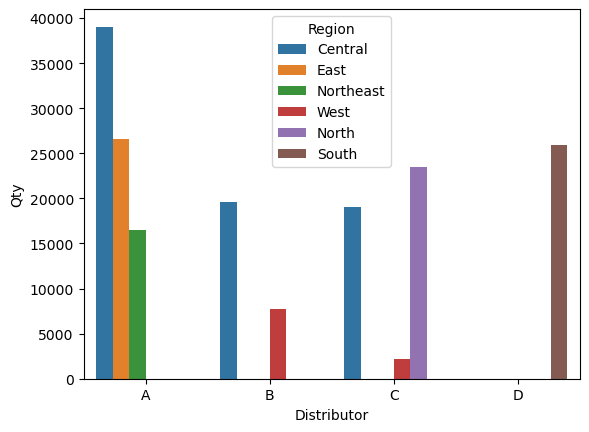

In [24]:
dist_by_region = mrw_with_region.groupby(['Distributor', 'Region']).agg({'Qty': 'sum', 'Total_Volume': 'sum'}).reset_index()

sns.barplot(data=dist_by_region, x='Distributor', y='Qty', hue='Region')

<Axes: xlabel='Region', ylabel='Qty'>

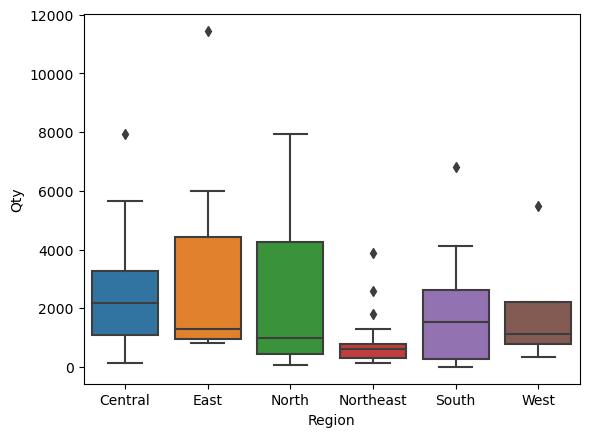

In [25]:
region_sales = mrw_with_region.groupby(['Region', 'Province']).agg({'Qty': 'sum', 'Total_Volume': 'sum'}).reset_index()

# distribution of total qty every province in each region not include bangkok
sns.boxplot(data=region_sales.drop(index=0), x='Region', y='Qty')

In [26]:
for i in region_sales['Region'].unique():
    num = len(region_sales[ region_sales['Region'] == i ])
    print(f"{i} have {num} provinces")

Central have 21 provinces
East have 8 provinces
North have 9 provinces
Northeast have 19 provinces
South have 14 provinces
West have 5 provinces
